In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter,FormatStrFormatter,StrMethodFormatter
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
portfolio = pd.read_json(r'C:\Desktop\portfolio.json', orient='records', lines=True)
profile = pd.read_json(r'C:\Desktop\profile.json', orient='records', lines=True)
transcript = pd.read_json(r'C:\Desktop\transcript.json', orient='records', lines=True)

In [3]:
df=pd.DataFrame(transcript['value'].values.tolist(),index=transcript.index)

In [4]:
transcript=transcript.merge(df,left_index=True, right_index=True)

In [5]:
#one hot encode channels
mlb = MultiLabelBinarizer()
channel = pd.DataFrame(mlb.fit_transform(portfolio['channels']),columns=mlb.classes_, index=portfolio.index)

In [6]:
portfolio=portfolio.merge(channel,left_index=True, right_index=True)

In [7]:
transcript=transcript.merge(portfolio, left_on='offer_id', right_on='id', how='left')

In [8]:
transcript=transcript.merge(profile, left_on='person', right_on='id', how='left')

In [9]:
transcript=transcript.merge(portfolio, left_on='offer id', right_on='id', how='left')

In [10]:
transcript_a=transcript[transcript['event']=='offer completed']\
.groupby(['offer_type_x','difficulty_x','reward_x','duration_x'])['event'].count()

In [11]:
transcript_a=transcript_a.reset_index()

In [12]:
transcript_a

,offer_type_x,difficulty_x,reward_x,duration_x,event
0,bogo,5.0,5.0,5.0,4296
1,bogo,5.0,5.0,7.0,4354
2,bogo,10.0,10.0,5.0,3331
3,bogo,10.0,10.0,7.0,3688
4,discount,7.0,3.0,7.0,5156
5,discount,10.0,2.0,7.0,4017
6,discount,10.0,2.0,10.0,5317
7,discount,20.0,5.0,10.0,3420


In [13]:
transcript_a=transcript_a.rename(columns={"offer_type_x": "offer_type",\
                             "difficulty_x": "difficulty",\
                             "reward_x": "reward",\
                             "duration_x":"duration",
                             "event":"Number of Offers Completed"})


In [14]:
transcript_b=transcript[(transcript['event']=='offer received') & (transcript['offer_type_y']!='informational')]\
.groupby(['offer_type_y','difficulty_y','reward','duration_y'])['event'].count()
# I omit O because it's unclear what gender it is so would not inform future targeting strategy

In [15]:
transcript_b=transcript_b.reset_index()

In [16]:
transcript_b=transcript_b.rename(columns={"offer_type_y": "offer_type",\
                             "difficulty_y": "difficulty",\
                             "duration_y":"duration",
                             "event":"Number of Offers Received"})


In [17]:
transcript_b

,offer_type,difficulty,reward,duration,Number of Offers Received
0,bogo,5.0,5.0,5.0,7571
1,bogo,5.0,5.0,7.0,7677
2,bogo,10.0,10.0,5.0,7593
3,bogo,10.0,10.0,7.0,7658
4,discount,7.0,3.0,7.0,7646
5,discount,10.0,2.0,7.0,7632
6,discount,10.0,2.0,10.0,7597
7,discount,20.0,5.0,10.0,7668


In [18]:
#inner join transcript_a and transcript_b on index
response=pd.merge(transcript_a, transcript_b, left_index=True, right_index=True)

In [19]:
response=response.drop(columns=['offer_type_y', 'difficulty_y','reward_y','duration_y'])\
.rename(columns={"offer_type_x": "offer_type",\
                             "difficulty_x": "difficulty",\
                             "reward_x": "reward",\
                             "duration_x":"duration"})

In [20]:
response['Percent of Offers Completed/Offers Received']=\
round((response['Number of Offers Completed']/response['Number of Offers Received']*100),1)

In [21]:
response

,offer_type,difficulty,reward,duration,Number of Offers Completed,Number of Offers Received,Percent of Offers Completed/Offers Received
0,bogo,5.0,5.0,5.0,4296,7571,56.7
1,bogo,5.0,5.0,7.0,4354,7677,56.7
2,bogo,10.0,10.0,5.0,3331,7593,43.9
3,bogo,10.0,10.0,7.0,3688,7658,48.2
4,discount,7.0,3.0,7.0,5156,7646,67.4
5,discount,10.0,2.0,7.0,4017,7632,52.6
6,discount,10.0,2.0,10.0,5317,7597,70.0
7,discount,20.0,5.0,10.0,3420,7668,44.6


In [22]:
response['Offer Type Variant']=response['offer_type'].str.upper()\
+":\n "+ "Spend: "+response['difficulty'].astype(str)\
+",\n Reward: "+response['reward'].astype(str)\
+",\n Duration: "+response['duration'].astype(str)
response
response=response.set_index('Offer Type Variant')
response=response.sort_values('Percent of Offers Completed/Offers Received',ascending=False)

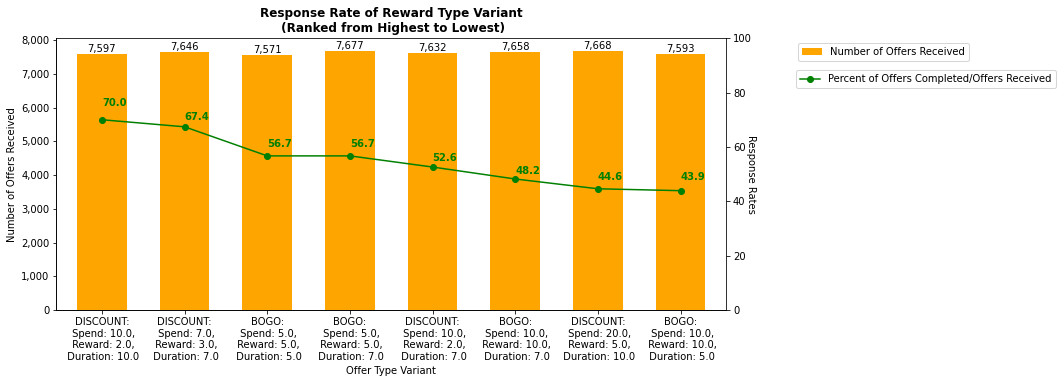

In [23]:
plt.figure(figsize=(12,5))
ax=response['Number of Offers Received'].plot(kind = "bar", width=.6, color='orange',legend=True)
plt.legend(bbox_to_anchor=(1.1, 1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.bar_label(ax.containers[0],fmt='{:,.0f}')
plt.xticks(rotation=360)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax1 = ax.twinx()
ax1.annotate('70.0', xy=(0, 75),color='green',weight='bold')
ax1.annotate('67.4', xy=(1, 70),color='green',weight='bold')
ax1.annotate('56.7', xy=(2, 60),color='green',weight='bold')
ax1.annotate('56.7', xy=(3, 60),color='green',weight='bold')
ax1.annotate('52.6', xy=(4, 55),color='green',weight='bold')
ax1.annotate('48.2', xy=(5, 50),color='green',weight='bold')
ax1.annotate('44.6', xy=(6, 48),color='green',weight='bold')
ax1.annotate('43.9', xy=(7, 48),color='green',weight='bold')
ax1=response['Percent of Offers Completed/Offers Received'].plot(kind = "line", marker='o',color='green',legend=True)
plt.legend(bbox_to_anchor=(1.5,.9))
ax.set_ylabel('Number of Offers Received')
ax1.set_ylabel('Response Rates', rotation=270)
ax1.set_ylim([0,100])
plt.title('Response Rate of Reward Type Variant\n (Ranked from Highest to Lowest)', weight='bold')
plt.show()